### Colab setup (can safely delete if you are running locally):

In [25]:
# ONLY RUN IN COLAB ONCE:
# Clean & Fast Setup (run once per session)
import os, sys, subprocess
from pathlib import Path

repo_url = "https://github.com/Leibniz-IWT/comp_eng.git"
repo_dir = "comp_eng"

if not Path(repo_dir).exists():
    print("Cloning repository (shallow clone - fast)...")
    !git clone --depth 1 {repo_url} {repo_dir} -q
else:
    print("Repository already cloned.")

%cd {repo_dir}/project_handout

# Make station_model importable
sys.path.insert(0, os.path.abspath("."))

# Install dependencies quietly
print("Installing dependencies...")
!pip install -q numpy scipy matplotlib sympy gymnasium stable-baselines3[extra] ipywidgets

print("✅ Setup complete! You can now open the handout notebook.")

Cloning repository (shallow clone - fast)...
/content/comp_eng/project_handout/comp_eng/project_handout
Installing dependencies...
✅ Setup complete! You can now open the handout notebook.


# Station Keeping Sub-Problem 1: Denoising Thruster and Drag Data

In this notebook, we visualize and analyze the noisy thruster and drag data provided in the `station_model` package. The goal is to understand the characteristics of the noise and how it affects the performance of the thrusters and drag model. This analysis will help in developing strategies to mitigate the impact of noise on the station-keeping task.

In order to get a good grade for this sub-problem, you need to fit your suggested function approximations that you believe the underlying "real" functions are based on before noise was added. You can use regression techniques of your choice to derive smooth approximations of the noisy data. The quality of your approximations will be evaluated based on how well they match the underlying real functions.

First we'll import and visualize the noisy data provided:

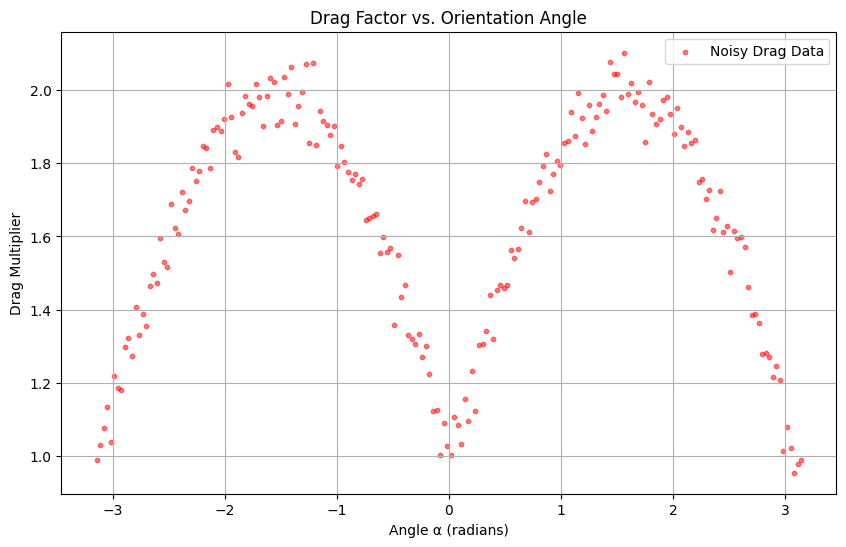

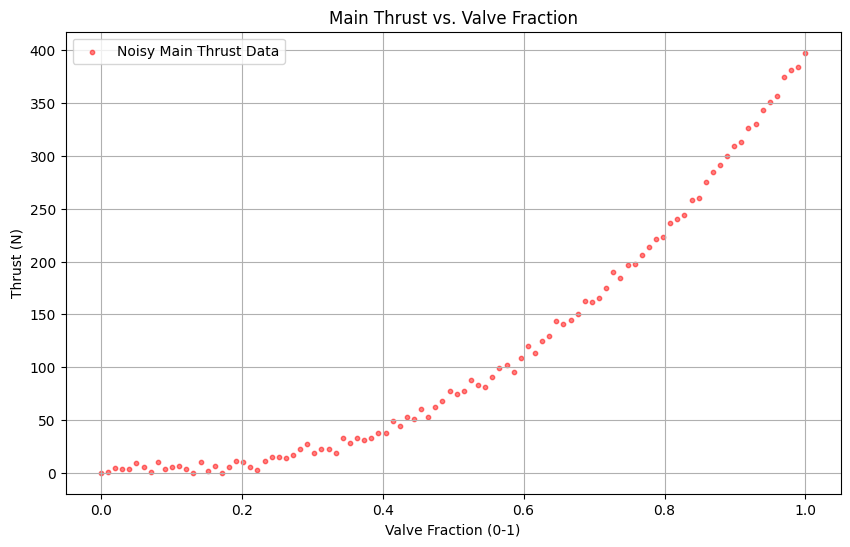

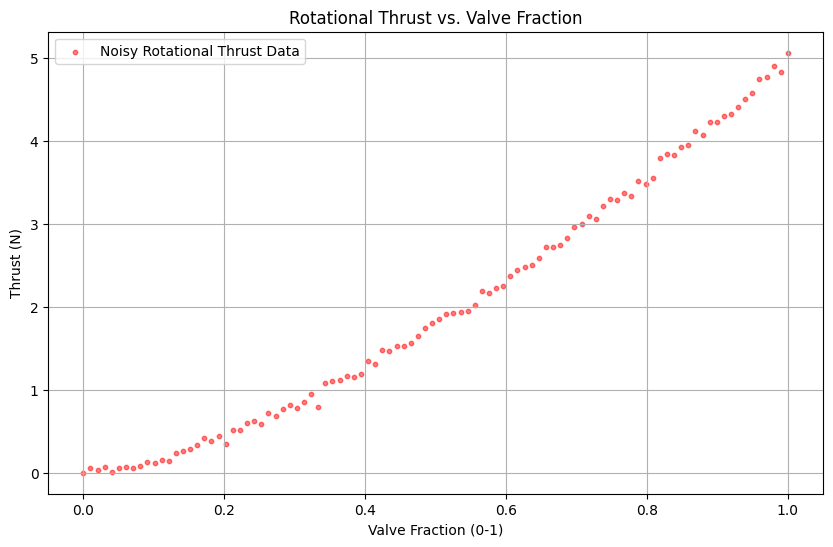

In [26]:
import matplotlib.pyplot as plt
from station_model._hidden_functions import alphas, noisy_drag, valves, noisy_thrust_main, noisy_thrust_rot, thrust_rot_interp, test_solutions, drag_interp, thrust_main_interp, thrust_rot_interp

# Assuming the provided code has already been run to define alphas, real_drag, noisy_drag, drag_interp,
# valves, real_thrust_main, noisy_thrust_main, thrust_main_interp,
# real_thrust_rot, noisy_thrust_rot, thrust_rot_interp

# Plot 1: Drag Factor
plt.figure(figsize=(10, 6))
plt.scatter(alphas, noisy_drag, label='Noisy Drag Data', color='red', s=10, alpha=0.5)
#plt.plot(alphas, drag_interp(alphas), label='Interpolated Noisy Drag', color='green')
plt.xlabel('Angle α (radians)')
plt.ylabel('Drag Multiplier')
plt.title('Drag Factor vs. Orientation Angle')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Main Thrust
plt.figure(figsize=(10, 6))

plt.scatter(valves, noisy_thrust_main, label='Noisy Main Thrust Data', color='red', s=10, alpha=0.5)
#plt.plot(valves, thrust_main_interp(valves), label='Interpolated Noisy Main Thrust', color='green')
plt.xlabel('Valve Fraction (0-1)')
plt.ylabel('Thrust (N)')
plt.title('Main Thrust vs. Valve Fraction')
plt.legend()
plt.grid(True)
plt.show()

# Plot 3: Rotational Thrust
plt.figure(figsize=(10, 6))
#plt.plot(valves, real_thrust_rot, label='Real Rotational Thrust', color='blue', linestyle='--')
plt.scatter(valves, noisy_thrust_rot, label='Noisy Rotational Thrust Data', color='red', s=10, alpha=0.5)
#plt.plot(valves, thrust_rot_interp(valves), label='Interpolated Noisy Rotational Thrust', color='green')
plt.xlabel('Valve Fraction (0-1)')
plt.ylabel('Thrust (N)')
plt.title('Rotational Thrust vs. Valve Fraction')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
import pandas as pd
import seaborn as sns

data_drag = {'alphas': alphas,
            'noisy drag':noisy_drag
            }

data_thrust = {'valves': valves,
            'noisy thrust main': noisy_thrust_main,
            'noisy thrust rot': noisy_thrust_rot
             }

In [28]:
df_drag = pd.DataFrame(data_drag)
df_thrust = pd.DataFrame(data_thrust)

### **Data of drag**

In [29]:
df_drag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   alphas      200 non-null    float64
 1   noisy drag  200 non-null    float64
dtypes: float64(2)
memory usage: 3.3 KB


In [30]:
df_drag.describe().T

,count,mean,std,min,25%,50%,75%,max
alphas,200.0,0.00000,1.827466,-3.141593,-1.570796,0.000000,1.570796,3.141593
noisy drag,200.0,1.63246,0.316030,0.954322,1.361712,1.701779,1.904238,2.101883


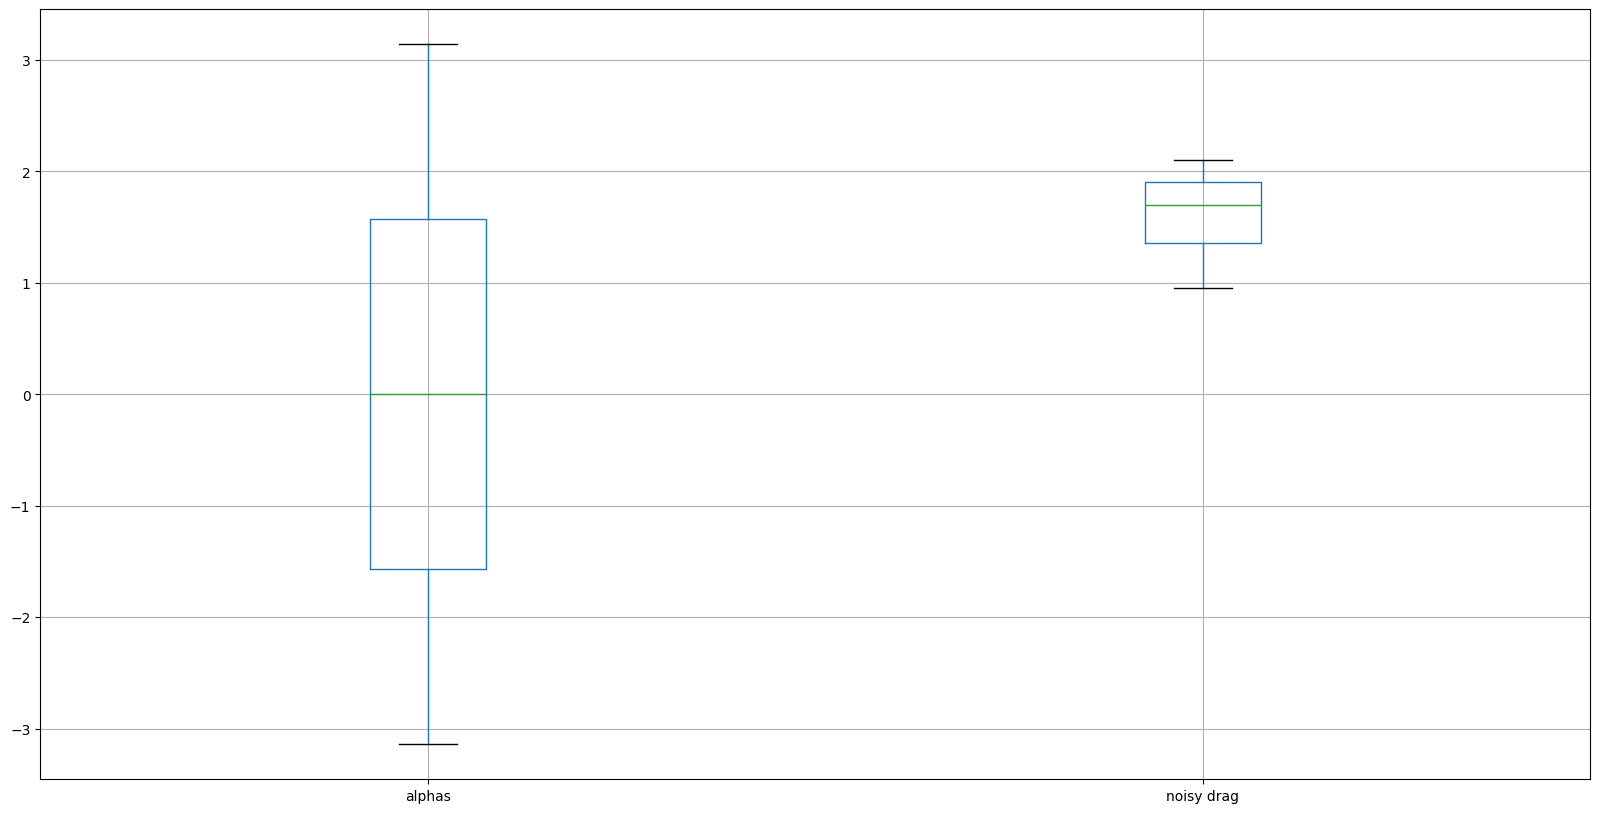

In [31]:
df_drag[['alphas','noisy drag']].boxplot(figsize=(20,10))
plt.show()

**Observations**:

* The data does not present outliers

<Axes: xlabel='alphas', ylabel='noisy drag'>

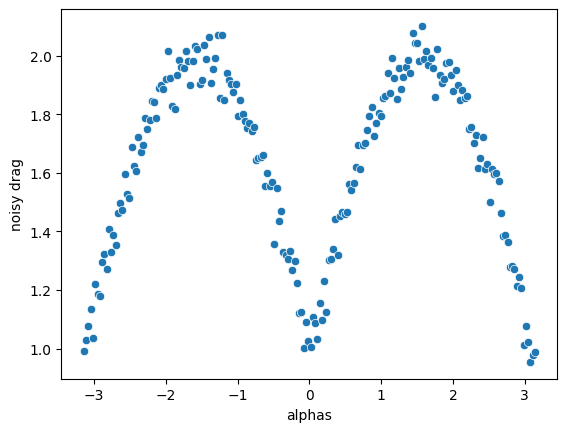

In [32]:
sns.scatterplot(x='alphas',y='noisy drag',data=df_drag)

**Observations**:

*  The data presents a curved path between -3 and 0, which is repeated between 0 and 3, so that the data has a non linear correlation.
*  With this analysis can be confirmed the regression function could be `f(α) = a + k ||   sin(α)||`.

### **Data of thrust**

In [33]:
df_thrust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   valves             100 non-null    float64
 1   noisy thrust main  100 non-null    float64
 2   noisy thrust rot   100 non-null    float64
dtypes: float64(3)
memory usage: 2.5 KB


In [34]:
df_thrust.describe().T

,count,mean,std,min,25%,50%,75%,max
valves,100.0,0.500000,0.293045,0.0,0.250000,0.500000,0.750000,1.000000
noisy thrust main,100.0,115.838937,118.039126,0.0,14.650696,75.672494,196.562675,397.733234
noisy thrust rot,100.0,2.004002,1.520317,0.0,0.615317,1.825603,3.288716,5.060301


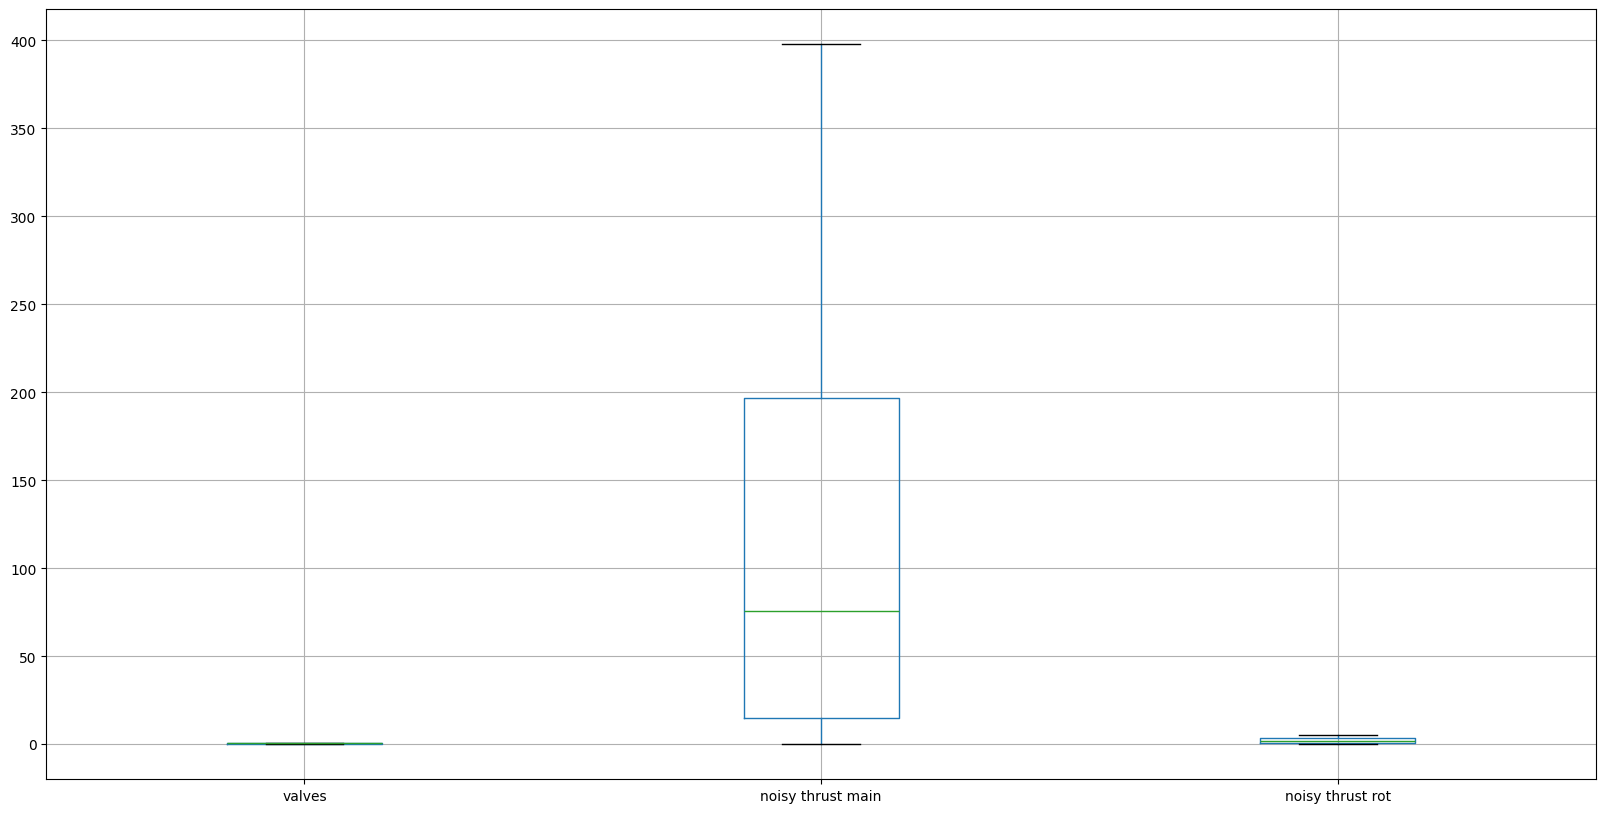

In [35]:
df_thrust[['valves','noisy thrust main', 'noisy thrust rot']].boxplot(figsize=(20,10))
plt.show()

**Observations:**

*  The data does not present outliers
*  The noisy thrust main data presents a higher array of data.

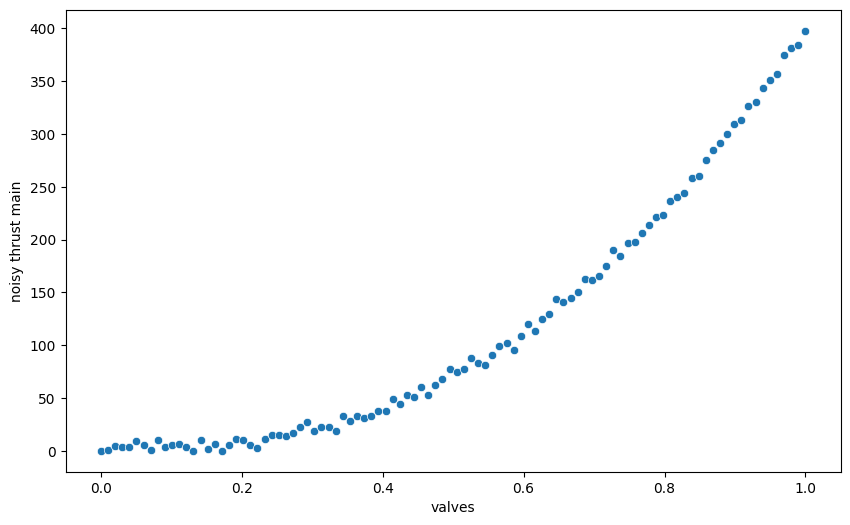

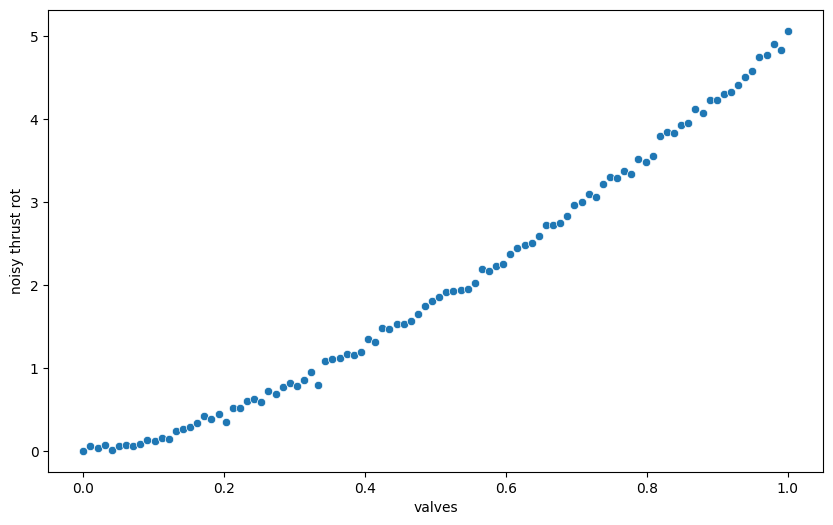

In [36]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='valves',y='noisy thrust main',data=df_thrust)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='valves',y='noisy thrust rot',data=df_thrust)
plt.show()

**Observations:**

*  The valve fraction contributes to the change of the thrust rotation and main thrust, making it be correlated in a positive linearity.
*  The main rotation presents a little curved shape between 0.4 and 0.8, which should be taken into account in the equation proposed `f(x) = b * x^n`.
*  n in the equation will be proposed by using non linear regression for every model.

## **First models**

In [37]:
import scipy as sp
import numpy as np

### **Drag model**

Fitted parameters [a, b, c]: [0.99756157 1.00232837]
Residual sum of squares: 0.26521402428553165


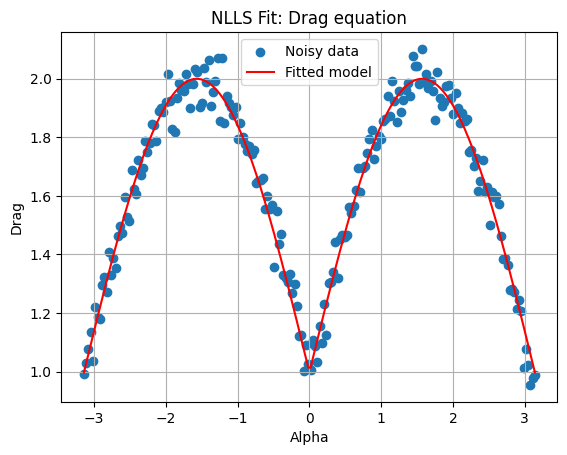

In [38]:
alpha = data_drag['alphas']

# Residual function
def residuals_drag(p, alpha, y):
    a, k = p
    return y - (a + k * abs(np.sin(alpha)))

p0 = [1, 1]

res_drag = sp.optimize.least_squares(residuals_drag, p0, args=(alpha, data_drag['noisy drag']), method='lm')
print("Fitted parameters [a, b, c]:", res_drag.x)
print("Residual sum of squares:", res_drag.cost)

# Plot results
plt.scatter(alpha, data_drag['noisy drag'], label='Noisy data')
plt.plot(alpha, res_drag.x[0]  + res_drag.x[1] * abs(np.sin(alpha)), 'r-', label='Fitted model')
plt.xlabel('Alpha')
plt.ylabel('Drag')
plt.title('NLLS Fit: Drag equation')
plt.legend()
plt.grid(True)
plt.show()

### **Error**

In [39]:
drag_interp_calc = res_drag.x[0]  + res_drag.x[1] * abs(np.sin(data_drag['alphas']))

In [40]:
# RSS
rss = np.sum((data_drag['noisy drag'] - drag_interp_calc)**2)

# MSE
mse = np.mean((data_drag['noisy drag'] - drag_interp_calc)**2)

# TSS
tss = np.sum((data_drag['noisy drag'] - np.mean(data_drag['noisy drag']))**2)

# R^2
r_squared = 1 - rss/tss

print("RSS:", rss)
print("MSE:", mse)
print("R^2:", r_squared)

RSS: 0.5304280485710633
MSE: 0.0026521402428553165
R^2: 0.9733119671716548


**Observations**:
*  The model seems to fit accordingly.
*  97.33% of the data is explained with the model, according with R square analysis.

### **Thrust model**

Fitted parameters - main thrust [b, n]: [398.937786     2.48474388]
Residual sum of squares: 797.4864848583525
Fitted parameters - main thrust [b, n]: [4.98570391 1.49198811]
Residual sum of squares: 0.12258187529214518


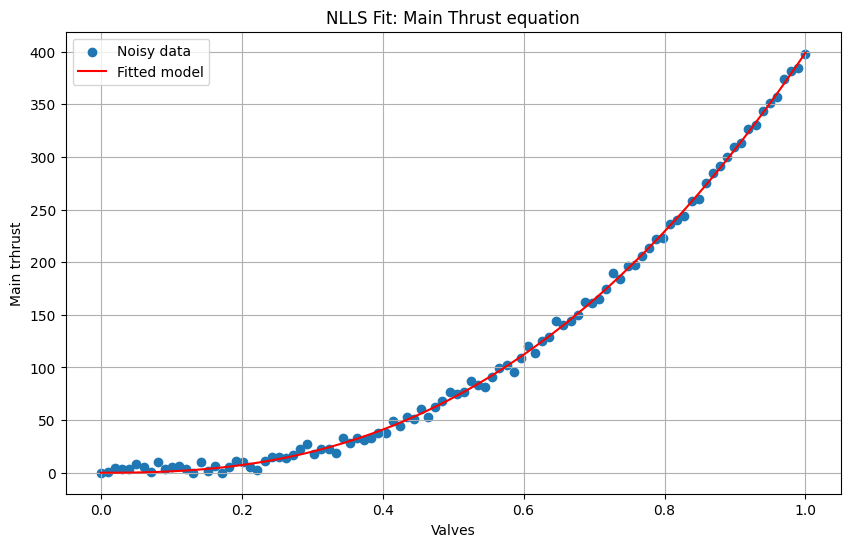

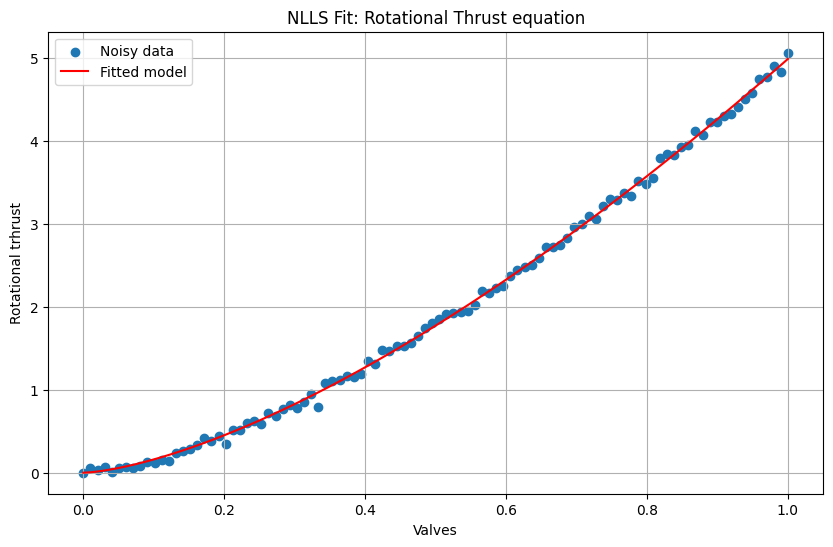

In [49]:
valves = data_thrust['valves']

# Residual function
def residuals_thrust(p, valves, y):
    b, n = p
    return y - (b * valves ** n)

p01 = [1, 0]
p02 = [1, 1]

#Main thrust
res_thrust_main = sp.optimize.least_squares(residuals_thrust, p01, args=(valves, data_thrust['noisy thrust main']), method='lm')
print("Fitted parameters - main thrust [b, n]:", res_thrust_main.x)
print("Residual sum of squares:", res_thrust_main.cost)

#Rotational thrust
res_thrust_rot = sp.optimize.least_squares(residuals_thrust, p0, args=(valves, data_thrust['noisy thrust rot']), method='trf')
print("Fitted parameters - main thrust [b, n]:", res_thrust_rot.x)
print("Residual sum of squares:", res_thrust_rot.cost)

# Plot results

plt.figure(figsize=(10, 6))
plt.scatter(valves, data_thrust['noisy thrust main'], label='Noisy data')
plt.plot(valves, res_thrust_main.x[0] * valves ** res_thrust_main.x[1], 'r-', label='Fitted model')
plt.xlabel('Valves')
plt.ylabel('Main trhrust')
plt.title('NLLS Fit: Main Thrust equation')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(valves, data_thrust['noisy thrust rot'], label='Noisy data')
plt.plot(valves, res_thrust_rot.x[0] * valves ** res_thrust_rot.x[1], 'r-', label='Fitted model')
plt.xlabel('Valves')
plt.ylabel('Rotational trhrust')
plt.title('NLLS Fit: Rotational Thrust equation')
plt.legend()
plt.grid(True)
plt.show()

### **Error**

In [42]:
thrust_main_interp_calc = res_thrust_main.x[0] * valves ** res_thrust_main.x[1]
thrust_rot_interp_calc = res_thrust_rot.x[0] * valves ** res_thrust_rot.x[1]

In [50]:
#Main Thrust
# RSS
rss = np.sum((data_thrust['noisy thrust main'] - thrust_main_interp_calc)**2)

# MSE
mse = np.mean((data_thrust['noisy thrust main'] - thrust_main_interp_calc)**2)

# TSS
tss = np.sum((data_thrust['noisy thrust main'] - np.mean(data_thrust['noisy thrust main']))**2)

# R^2
r_squared = 1 - rss/tss

print('Main thrust')
print("RSS:", rss)
print("MSE:", mse)
print("R^2:", r_squared,'\n')

#Rotational thrust
# RSS
rss = np.sum((data_thrust['noisy thrust rot'] - thrust_rot_interp_calc)**2)

# MSE
mse = np.mean((data_thrust['noisy thrust rot'] - thrust_rot_interp_calc)**2)

# TSS
tss = np.sum((data_thrust['noisy thrust rot'] - np.mean(data_thrust['noisy thrust rot']))**2)

# R^2
r_squared = 1 - rss/tss

print('Rotational thrust')
print("RSS:", rss)
print("MSE:", mse)
print("R^2:", r_squared)

Main thrust
RSS: 1594.972969716705
MSE: 15.949729697167049
R^2: 0.9988437116221198 

Rotational thrust
RSS: 0.24516375058428982
MSE: 0.0024516375058428984
R^2: 0.9989285975144243


**Observations:**

*  The main thrust model is getting 99.88% of accuracy.
*  The second model is getting a good approximation of the points.

In [51]:
def drag_interpr(alphas):
  return res_drag.x[0]  + res_drag.x[1] * abs(np.sin(alphas))

def thrust_main_interpr(valves):
  return res_thrust_main.x[0] * valves ** res_thrust_main.x[1]

def thrust_rot_interpr(valves):
  return res_thrust_rot.x[0] * valves ** res_thrust_rot.x[1]

# Test solutions:

Once you have successfully created your function approximations, replace the funcction inputs `drag_interp`, `thrust_main_interp`, `thrust_rot_interp` below as an input to the provided `test_solutions` function. This function will evaluate how well your approximations match the underlying real functions and provide feedback on their accuracy.

In [52]:
test_solutions(drag_interpr , thrust_main_interpr, thrust_rot_interpr)

Drag Factor L2-norm error: 0.017032
Main Thrust L2-norm error: 4.214879
Rotational Thrust L2-norm error: 0.055201
Success! All tests passed.


If you get the message `"Success! All tests passed."` (When all the L-2 norms are less than 0.05), you have successfully completed this sub-problem!

>HINT: The drag factor function is of the form `f(α) = a + k ||   sin(α)||` while the thrust functions are of the form `f(x) = b * x^n` where `a`, `k`, `b` and `n` are constants to be determined through regression techniques.